In [1]:
import pm4py
import csv
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
import os
import pickle
import tqdm as notebook_tqdm

# Using the user account balance to filter the log
The log has an overall size of 23 Mio events. ProM can barely ~1.5 Mio events. Hence, the log size needs to be reduced. Note: In the pyramide the top performers are at the very tip of the pyramide, which includes only a small percentage of user. 

Method: 
- Samples of same size to get comparable frequencies in event execution
- Performance metric: account balance
- Top: 1000 addresses with highest balance; Middle: 1000 addresses between 75 and 50 quantile; Bottom: 1000 addresses with lowest balance (highest negative)
- Export logs for ProM and Disco analysis

In [2]:
# load balance sheet (see 1_Forsage_Ether_analysis.ipynb)

curr_dir = os.getcwd()
dir_path = os.path.dirname(curr_dir)
file = "balance"
path = os.path.join(dir_path, "resources", file + ".pkl")
balance = pickle.load(open(path, 'rb'))

Text(0, 0.5, 'Number of accounts (log scale)')

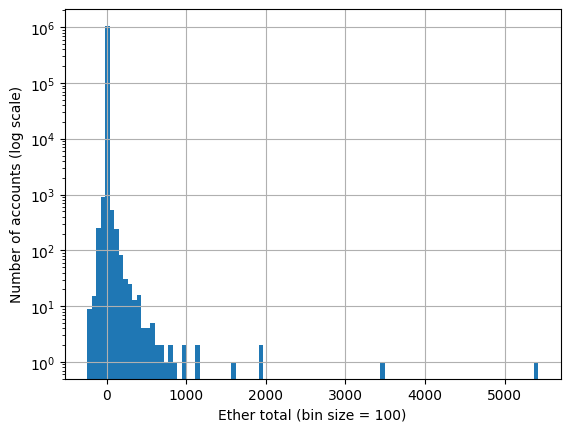

In [3]:
# distribution of total ETH per address (first graphic impression of income distribution)

bin_size = 100
balance["total_ETH"].hist(bins=bin_size)
plt.yscale('log')
plt.xlabel("Ether total (bin size = 100)")
plt.ylabel("Number of accounts (log scale)")

In [4]:
# create user address samples based on the balance

sample_size = 1000

def pyramide_cutter(mask):
    pyramide_slice = balance[mask]
    pyramide_slice = pyramide_slice.sample(n=sample_size, random_state=1, replace=False)
    pyramide_slice = pyramide_slice.address.reset_index().drop(columns='index')
    pyramide_slice = pyramide_slice.address.tolist()
    return pyramide_slice

# SUCCESSFUL USERS
pyramide_top = balance.nlargest(sample_size+1, "total_ETH") # +1 -> the balance sheet contains a Forsage contract with a high balance but no activities assigned to it as a case notion in the event log
pyramide_top = pyramide_top.address.reset_index().drop(columns='index')
pyramide_top = pyramide_top.address.tolist()

# AVERAGE USERS, center of the pyramide -> between median and 3rd quartile
quartiles = balance.total_ETH.quantile([0.25, 0.5, 0.75])
mask_center_top = (balance.total_ETH>=quartiles[0.5])&(balance.total_ETH<=quartiles[0.75])
pyramide_center_top = pyramide_cutter(mask_center_top)

# UNSUCCESSFUL USERS, bottom of the pyramide, little income or negative
pyramide_bottom = balance.nsmallest(sample_size, "total_ETH")
pyramide_bottom = pyramide_bottom.address.reset_index().drop(columns='index')
pyramide_bottom = pyramide_bottom.address.tolist()

In [5]:
# Load Forsage log for trace sampling

path = "<path-to-Forsage-XES-log>"

log = pm4py.read_xes(path)
df_log = pm4py.convert_to_dataframe(log)

del log

parsing log, completed traces ::   0%|          | 0/1055931 [00:00<?, ?it/s]

In [6]:
# create log samples for user groups

def log_cutter(pyramide_slice):
    mask = df_log["case:concept:name"].isin(pyramide_slice)
    df_sublog = df_log[mask]
    df_sublog = df_sublog.fillna('')
    df_sublog['time:timestamp'] = pd.to_datetime(df_sublog['time:timestamp'])
    # order by timestamp and logIndex
    df_sublog.sort_values(by=['time:timestamp', 'logIndex'], inplace = True)
    # add levels to activity labels
    mask_level = df_sublog["level"] != ""
    df_sublog['level'] = df_sublog['level'].apply(str).str[:-2]
    df_sublog.iloc[(mask_level).values, 5] = df_sublog[["concept:name", "level"]][mask_level].apply(" : Level ".join, axis=1)
    # fix index and columns
    df_sublog.reset_index(inplace=True)
    df_sublog.drop(columns=["index"], inplace=True)
    # first three events in each trace are onboarding matrices
    df_sublog.loc[df_sublog.groupby('case:concept:name').head(3)["concept:name"].index, "concept:name"] = "Onboarding: " + df_sublog["concept:name"]
    return df_sublog

df_top = log_cutter(pyramide_top)
df_center_top = log_cutter(pyramide_center_top)
df_bottom = log_cutter(pyramide_bottom)

In [7]:
# save log as dataframe

curr_dir = os.getcwd()
dir_path = os.path.dirname(curr_dir)

file = "df_log"
path = os.path.join(dir_path, "resources", file + ".pkl")
pickle.dump(df_log, open(path, 'wb'))

In [8]:
# save user addresses

curr_dir = os.getcwd()
dir_path = os.path.dirname(curr_dir)

data_list = [pyramide_top, pyramide_center_top, pyramide_bottom]
file_list = ["pyramide_top", "pyramide_center_top", "pyramide_bottom"]
counter_list = [0,1,2]

for i in counter_list:
    path = os.path.join(dir_path, "resources", file_list[i] + ".pkl")
    pickle.dump(data_list[i], open(path, 'wb'))

In [9]:
# save sample logs

curr_dir = os.getcwd()
dir_path = os.path.dirname(curr_dir)

data_list = [df_top, df_center_top, df_bottom]
file_list = ["df_top", "df_center_top", "df_bottom"]
counter_list = [0,1,2]

for i in counter_list:
    path = os.path.join(dir_path, "resources", file_list[i] + ".pkl")
    pickle.dump(data_list[i], open(path, 'wb'))

In [10]:
# or save log as XES

# convert to dataframe to XES
from pm4py.objects.conversion.log import converter as log_converter

log_top = log_converter.apply(df_top)
log_center_top = log_converter.apply(df_center_top)
log_bottom = log_converter.apply(df_bottom)

# export as XES
from pm4py.objects.log.exporter.xes import exporter as xes_exporter

curr_dir = os.getcwd()
dir_path = os.path.dirname(curr_dir)

data_list = [log_top, log_center_top, log_bottom]
file_list = ["log_top", "log_center_top", "log_bottom"]
counter_list = [0,1,2]

for i in counter_list:
    path = os.path.join(dir_path, "resources", file_list[i] + ".xes")
    xes_exporter.apply(data_list[i], path)

exporting log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]